In [1]:
using DifferentialEquations, Plots, Polynomials

## The ODE system

We will work with the following ODE system and analyze its identifiability from the steady state data for the variables $X$, $T_1$, $T_2$. The values of interest are the values of parameters $k_{D_1}$ and $k_{D_2}$.

In [2]:
function ss(du,u,p,t)
    X, T₁, T₂, D₁, D₂, Y = u
    kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kn₁*T₁*X -kn₂*T₂*X +kf₁*D₁ +kf₂*D₂
    du[2]= -kn₁*T₁*X +kf₁*D₁ -kn₁*T₁*D₂ +kf₁*Y
    du[3]= -kn₂*T₂*X +kf₂*D₂ -kn₂*T₂*D₁ +kf₂*Y
    du[4]= +kn₁*T₁*X -kf₁*D₁ -kn₂*T₂*D₁ +kf₂*Y
    du[5]= +kn₂*T₂*X -kf₂*D₂ -kn₁*T₁*D₂ +kf₁*Y
    du[6]= +kn₁*T₁*D₂ +kn₂*T₂*D₁ -(kf₁+kf₂)*Y
end
p = [1.72,19.66,1.57,0.74]
kD = [p[2] / p[1], p[4] / p[3]] # <----- WANTED

2-element Vector{Float64}:
 11.430232558139535
  0.47133757961783435

## Identifiability from two experiments

We start with computing the steady states by taking a sufficiently long timespan

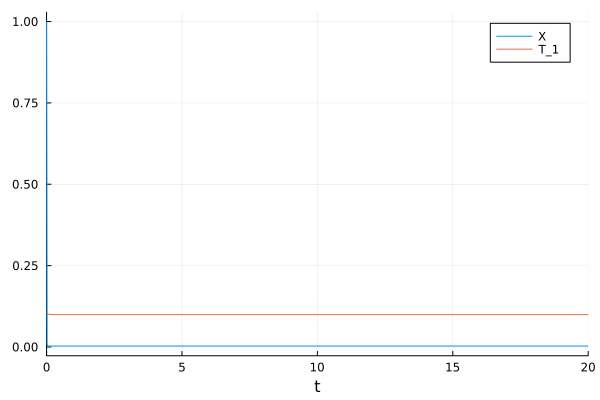

In [3]:
timespan = (0.0, 20.0)
initconc = [1e0, 1.08e-1, 166, 0.0, 0.0, 0.0]
dproblem = ODEProblem(ss, initconc, timespan, p)
sol = solve(dproblem)
plot(sol, vars=(0, 1), label="X")
plot!(sol, vars=(0, 2), label="T_1")

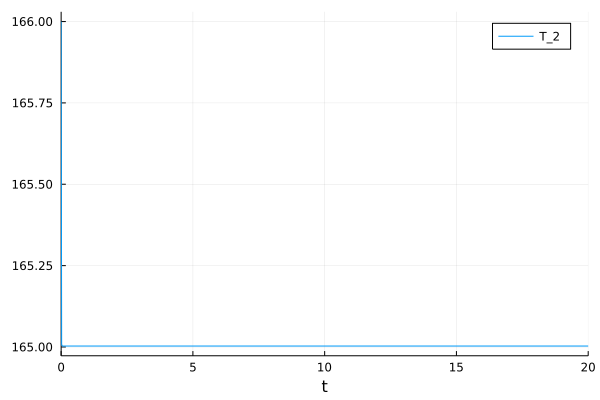

In [4]:
plot(sol, vars=(0, 3), label="T_2")

In [5]:
# steady state for X, T1, T2
sol[1, end], sol[2, end], sol[3, end]

(0.002823853430159511, 0.09938042011368256, 165.00284840548878)

Now we perform experiment with perturbed $X$. For each of these new experiments, we use the formulas from the paper to compute $k_{D_1}$ and $k_{D_2}$ from the original steady state and the new one.

In [7]:
"""
    Function for finding the values of kD's using the formulas from the paper.
    Takes as input pairs of value of X, T1, and T2 (from the first and the second experiment)
"""
function find_sol_kDs(X, T1, T2)
    # A1 * kD1^2 + A2 * kD1 + A3 = 0
    A3 = (T1[1]*X[1]-T1[2]*X[2])*(T1[1]*T2[1]*X[1]-T1[2]*T2[2]*X[2])
    A2 = (T1[1]^2*T2[1]*X[1]-T1[1]*T1[2]*T2[1]*X[1]-T1[1]*T1[2]*T2[2]*X[2]-T1[1]*T2[1]^2*X[1]+T1[1]*T2[1]*T2[2]*X[1]+T1[1]*T2[1]*X[1]^2-T1[1]*T2[2]*X[1]*X[2]+T1[2]^2*T2[2]*X[2]+T1[2]*T2[1]*T2[2]*X[2]-T1[2]*T2[1]*X[1]*X[2]-T1[2]*T2[2]^2*X[2]+T1[2]*T2[2]*X[2]^2)
    A1 = (T2[1]*X[1]-T2[2]*X[2])*(T1[1]-T1[2])
    
    # B1 * kD2 + B2 * kD1 + B3 = 0
    B1 = (T2[1]-T2[2])*(T1[1]*X[1]-T1[2]*X[2])
    B2 = -(T2[1]*X[1]-T2[2]*X[2])*(T1[1]-T1[2])
    B3 = -(T1[1]-T1[2]-T2[1]+T2[2])*(T1[1]*T2[1]*X[1]-T1[2]*T2[2]*X[2])
    p = Polynomial([A3, A2, A1])
    println("Roots for kD1: $(roots(p))")
    for r in roots(p)
        kD2 = (-B3 - B2 * r) / B1
        println("Solution: kD1 = $r and kD2 = $kD2")
    end
end

println("True values kD1 = $(kD[1]) and kD2 = $(kD[2])")

for delta_x in [0.1, -0.1]
    initconc2 = [1e0 + delta_x,1.08e-1,166,0.0,0.0,0.0]
    dproblem2 = ODEProblem(ss, initconc2, timespan, p)
    sol2 = solve(dproblem2)
    X = [sol[1, end], sol2[1, end]]
    T1 = [sol[2, end], sol2[2, end]]
    T2 = [sol[3, end], sol2[3, end]]
    println("==================")
    println("For second experiment with perturbing X by $delta_x")
    find_sol_kDs(X, T1, T2)
end

True values kD1 = 11.430232558139535 and kD2 = 0.47133757961783435
For second experiment with perturbing X by 0.1
Roots for kD1: [-0.00026028010474308166, 11.430232555196689]
Solution: kD1 = -0.00026028010474308166 and kD2 = -162.52946006749696
Solution: kD1 = 11.430232555196689 and kD2 = 0.4713375792512397
For second experiment with perturbing X by -0.1
Roots for kD1: [-0.00026412539908804623, 11.430232555652918]
Solution: kD1 = -0.00026412539908804623 and kD2 = -162.72219736340037
Solution: kD1 = 11.430232555652918 and kD2 = 0.47133757874646304


We see that the first solutions coincide with high precision (8 digits) and yield the original parameter values.

For these numerical values, the second solution can be discarded since it is negative. However, if it was positive, the second experiment can be used to discard the incorrect value thus three experiments would suffice.

## Is one experiment sufficient?

In order to show that a single experiment was not sufficient, we will now cook up different initial conditions and parameter values yielding the same steady state data for $X$, $T_1$, and $T_2$.

In [8]:
c = 1.1
D1_ = sol[4, end] * c
D2_ = sol[5, end] * c
Y_ = sol[6, end] * c^2
kD_ = kD ./ c

2-element Vector{Float64}:
 10.391120507399576
  0.4284887087434857

In [9]:
initconc_ = [
    sol[1, end] + Y_ + D1_ + D2_, 
    sol[2, end] + Y_ + D1_, 
    sol[3, end] + Y_ + D2_, 
    0.0, 0.0, 0.0
]
p_ = [1., kD_[1], 1., kD_[2]]
dproblem_ = ODEProblem(ss, initconc_, timespan, p_)
sol_ = solve(dproblem_)
sol_[1, end], sol_[2, end], sol_[3, end]

(0.0028238534301511043, 0.09938042011043911, 165.00284840548883)

Here are the original steady state for comparison. We observe that they coincide up to high order

In [10]:
sol[1, end], sol[2, end], sol[3, end]

(0.002823853430159511, 0.09938042011368256, 165.00284840548878)

However, as the following plots show, the overall dynamics was different

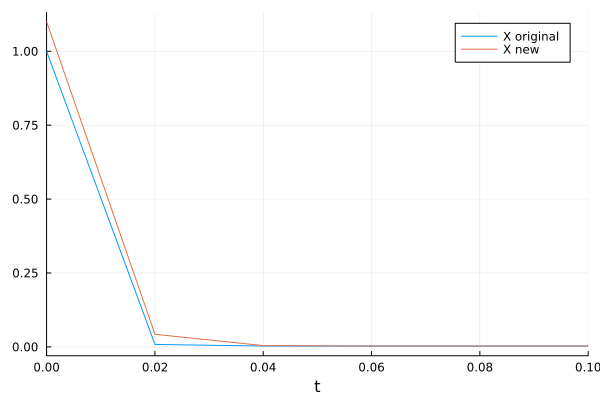

In [11]:
plot(sol, vars=(0, 1), label="X original", xlim=(0., 0.1))
plot!(sol_, vars=(0, 1), label="X new", xlim=(0., 0.1))

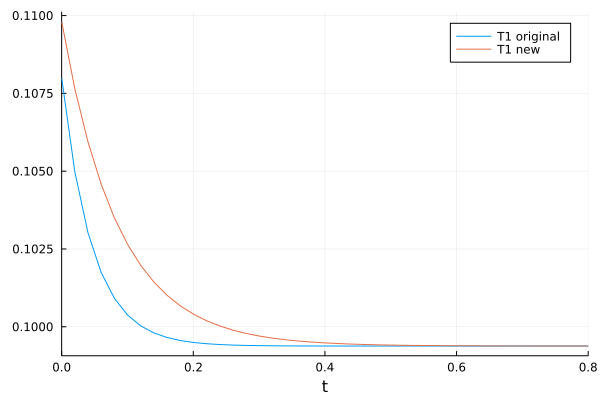

In [12]:
plot(sol, vars=(0, 2), label="T1 original", xlim=(0., 0.8))
plot!(sol_, vars=(0, 2), label="T1 new", xlim=(0., 0.8))

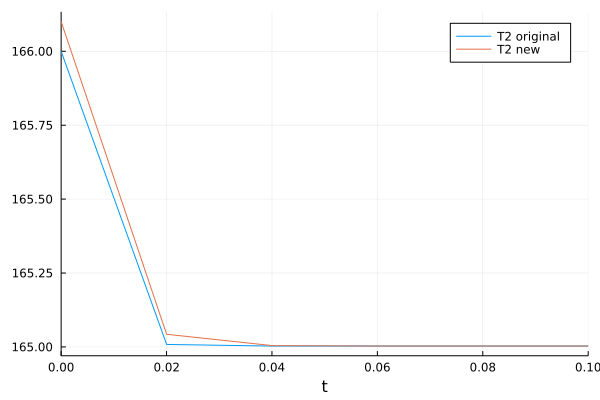

In [13]:
plot(sol, vars=(0, 3), label="T2 original", xlim=(0., 0.1))
plot!(sol_, vars=(0, 3), label="T2 new", xlim=(0., 0.1))